# Walkthrough: Identidog - A Dog Identification App 

---
Identidog is a dog breed identification app that takes an image of a dog or human as input and estimates the most resembling dog breeds! Here's screenshot of the app's interface: 

![Sample Dog Output](walkthrough_imgs/app_screenshot.jpg)

This notebook walks through the development of the app. It is based on the dog-classification project from the [public udacity repository](https://github.com/udacity/deep-learning-v2-pytorch/tree/master/project-dog-classification)


### Overview

We divide the notebook into separate steps:

* [Step 0](#step0): Import Data and Exploratory Analysis
* [Step 1](#step1): Make a face detector using OpenCV
* [Step 2](#step2): Make a dog detector with pretrained VGG16 CNN from PyTorch Hub
* [Step 3](#step3): Train a CNN to Classify Dog Breeds using Transfer Learning and Fastai
* [Step 4](#step4): Write app and deploy with Gradio
* [Step 5](#step5): Final Thoughts

---

<a id='step0'></a>
## Step 0: Import Data and Exploratory Analysis

Udacity generously shares links to the following dog and human datasets:
* [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip) (8351 images).   

* [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip) (13331 images).

To follow along, please download the data into the folders `data/dogImages` and `data/lfw` respectively (e.g. via running cell below), though we remark that the human dataset will only be used for evaluation of models, not training, and can be substituted with own supply of images. 

In [ ]:
# Uncomment to download and unzip dog and human images if on linux machine
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip "dogImages.zip" -d "data"
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
# !unzip "lfw.zip" -d "data" -x "__MACOSX/*"
# !rm "lfw.zip" "dogImages.zip"

In the following code cells, we setup the environment by loading all relevant libraries and data. 

**Notes**: 
- If running via Google Colab, it is necessary to first install gradio via pip.
- Type hints for dictionary and tuple objects aren't natively supported in python versions =< 3.9 - in these cases, import the necessary classes (``Dict`` and ``Tuple``) from the library ``Typing`` or simply remove them.
- In server environments (e.g. Docker/Binder), make sure to install ``opencv-python-headless`` instead of ``py-opencv`` for correct OpenCV dependencies.

In [ ]:
# Uncomment if gradio not installed.
# !pip install gradio

In [1]:
# import used libraries
import random
from collections import Counter
from operator import itemgetter

import cv2
import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm

# importing pytorch and fastai
from fastai.vision.all import *
import torch
from torchvision import models, transforms

# import pillow and set it be tolerant of truncated files
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

# for inline plotting
%matplotlib inline

In [5]:
# Save path to dog images for reuse
dog_path = Path("data/dogImages")

# Load filenames for human and dog images
human_files = get_image_files("data/lfw")
dog_files = get_image_files(dog_path)

# Print number of images in each dataset
print(f"There are {len(human_files)} total human images.")
print(f"There are {len(dog_files)} total dog images.")

# Split the dog data into training, validation, and test set
tvt = ["train", "valid", "test"]
dog_tvt = {split: get_image_files(dog_path, folders=split) for split in tvt}
tvt_lengths = {split: len(dog_tvt[split]) for split in tvt}
print(f"Dog images are split into the following sets: {tvt_lengths}")

There are 13233 total human images.
There are 8351 total dog images.
Dog images are split into the following sets: {'train': 6680, 'valid': 835, 'test': 836}


Observe that our data has already been split into training, validation and test sets containing 80/10/10% of the total images respectively.

To see which breeds we will be considering, let's gather all unique breeds into a tuple. 
We accomplish this by writing a function to get the breed name from a filename and applying it to the dog image files.

In [6]:
# gathering breeds
def get_breed_name(filepath: Path) -> str:
    """
    Function to grab dog breed name from full pathname.
    The name can be obtained by dropping the last 10
    characters from filename and converting underscores
    to spaces.

    Input:
        filepath as Path object.
    Output:
        breed name as string.
    """
    return filepath.name[:-10].replace("_", " ")


breeds = tuple(sorted({get_breed_name(dog) for dog in dog_files}))

# print info
print("Number of distinct breeds:", len(breeds))
breeds

Number of distinct breeds: 133


('Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute',
 'American eskimo dog',
 'American foxhound',
 'American staffordshire terrier',
 'American water spaniel',
 'Anatolian shepherd dog',
 'Australian cattle dog',
 'Australian shepherd',
 'Australian terrier',
 'Basenji',
 'Basset hound',
 'Beagle',
 'Bearded collie',
 'Beauceron',
 'Bedlington terrier',
 'Belgian malinois',
 'Belgian sheepdog',
 'Belgian tervuren',
 'Bernese mountain dog',
 'Bichon frise',
 'Black and tan coonhound',
 'Black russian terrier',
 'Bloodhound',
 'Bluetick coonhound',
 'Border collie',
 'Border terrier',
 'Borzoi',
 'Boston terrier',
 'Bouvier des flandres',
 'Boxer',
 'Boykin spaniel',
 'Briard',
 'Brittany',
 'Brussels griffon',
 'Bull terrier',
 'Bulldog',
 'Bullmastiff',
 'Cairn terrier',
 'Canaan dog',
 'Cane corso',
 'Cardigan welsh corgi',
 'Cavalier king charles spaniel',
 'Chesapeake bay retriever',
 'Chihuahua',
 'Chinese crested',
 'Chinese shar-pei',
 'Chow cho

Thus our dataset has images of 133 unique dog breeds! We remark that there are currently 356 recognised different dog breeds according to the International Canine Federation [FCI](https://www.fci.be/en/), so our dataset covers only 37% of all unique breeds(!), albeit of the most popular ones.

Let's see some example images:

Breed: Chesapeake bay retriever


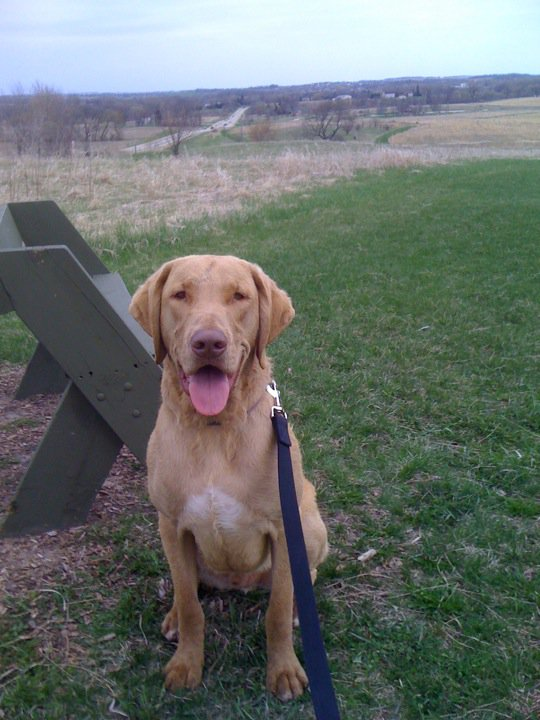

Breed: Brittany


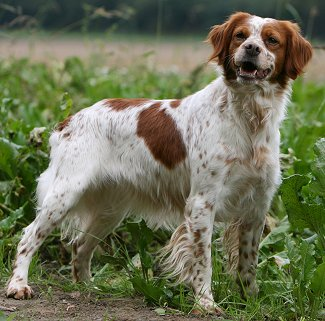

Breed: Norwegian buhund


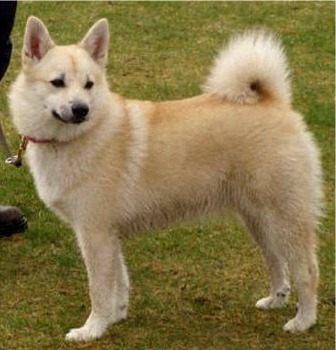

Breed: Bernese mountain dog


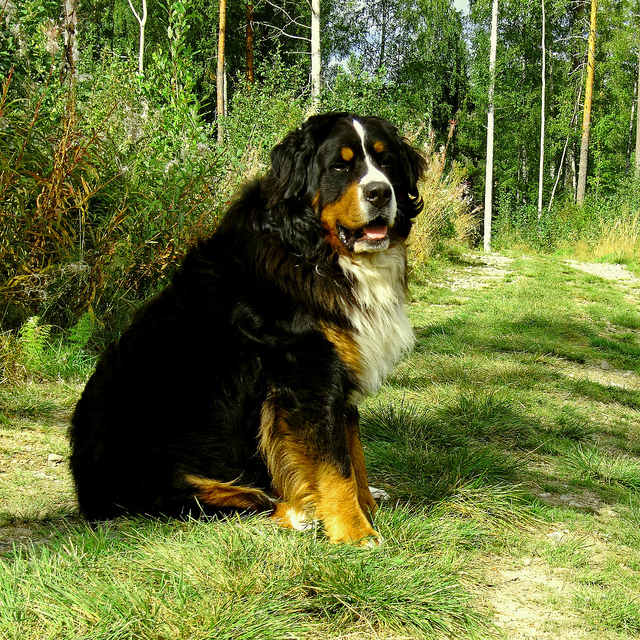

Breed: Cairn terrier


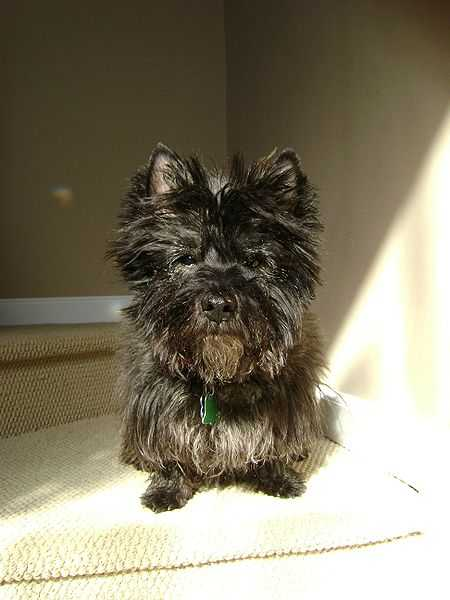

In [7]:
def get_sample(files: L, sample_size: int) -> np.array:
    """
    Function returns random sample of size: sample_size from numpy
    array of given files.

    Input:
        files: (fastai) list of files
        sample_size: integer number of samples
    Outputs:
        Sample files as numpy array
    """
    return np.random.choice(files, sample_size, replace=False)


# making random sample
dog_train = dog_tvt["train"]
dog_sample = get_sample(dog_train, 5)

# open images of sample
for dog in dog_sample:
    print("Breed:", get_breed_name(dog))
    with Image.open(dog) as img:
        display(img)

We see that our dog images come in a variety of qualities, sizes, poses and locations. To get a better idea at how our data is dispersed over breeds we plot a stacked horizontal barplot of counts using pandas and matplotlib.

In [8]:
# creating list of breeds and corresponding count
no_breeds_tvt = {
    split: (Counter(get_breed_name(file) for file in dog_tvt[split])) for split in tvt
}
# putting counts into dataframe
dog_df = pd.DataFrame(no_breeds_tvt, index=breeds, dtype=int)
# add totals column
dog_df["total"] = dog_df.sum(axis=1)
# show dataframe
dog_df

train  valid  test  total
Affenpinscher                   64      8     8     80
Afghan hound                    58      7     8     73
Airedale terrier                52      7     6     65
Akita                           63      8     8     79
Alaskan malamute                77      9    10     96
...                            ...    ...   ...    ...
Tibetan mastiff                 48      6     6     60
Welsh springer spaniel          44      6     5     55
Wirehaired pointing griffon     30      4     3     37
Xoloitzcuintli                  26      4     3     33
Yorkshire terrier               30      4     4     38

[133 rows x 4 columns]

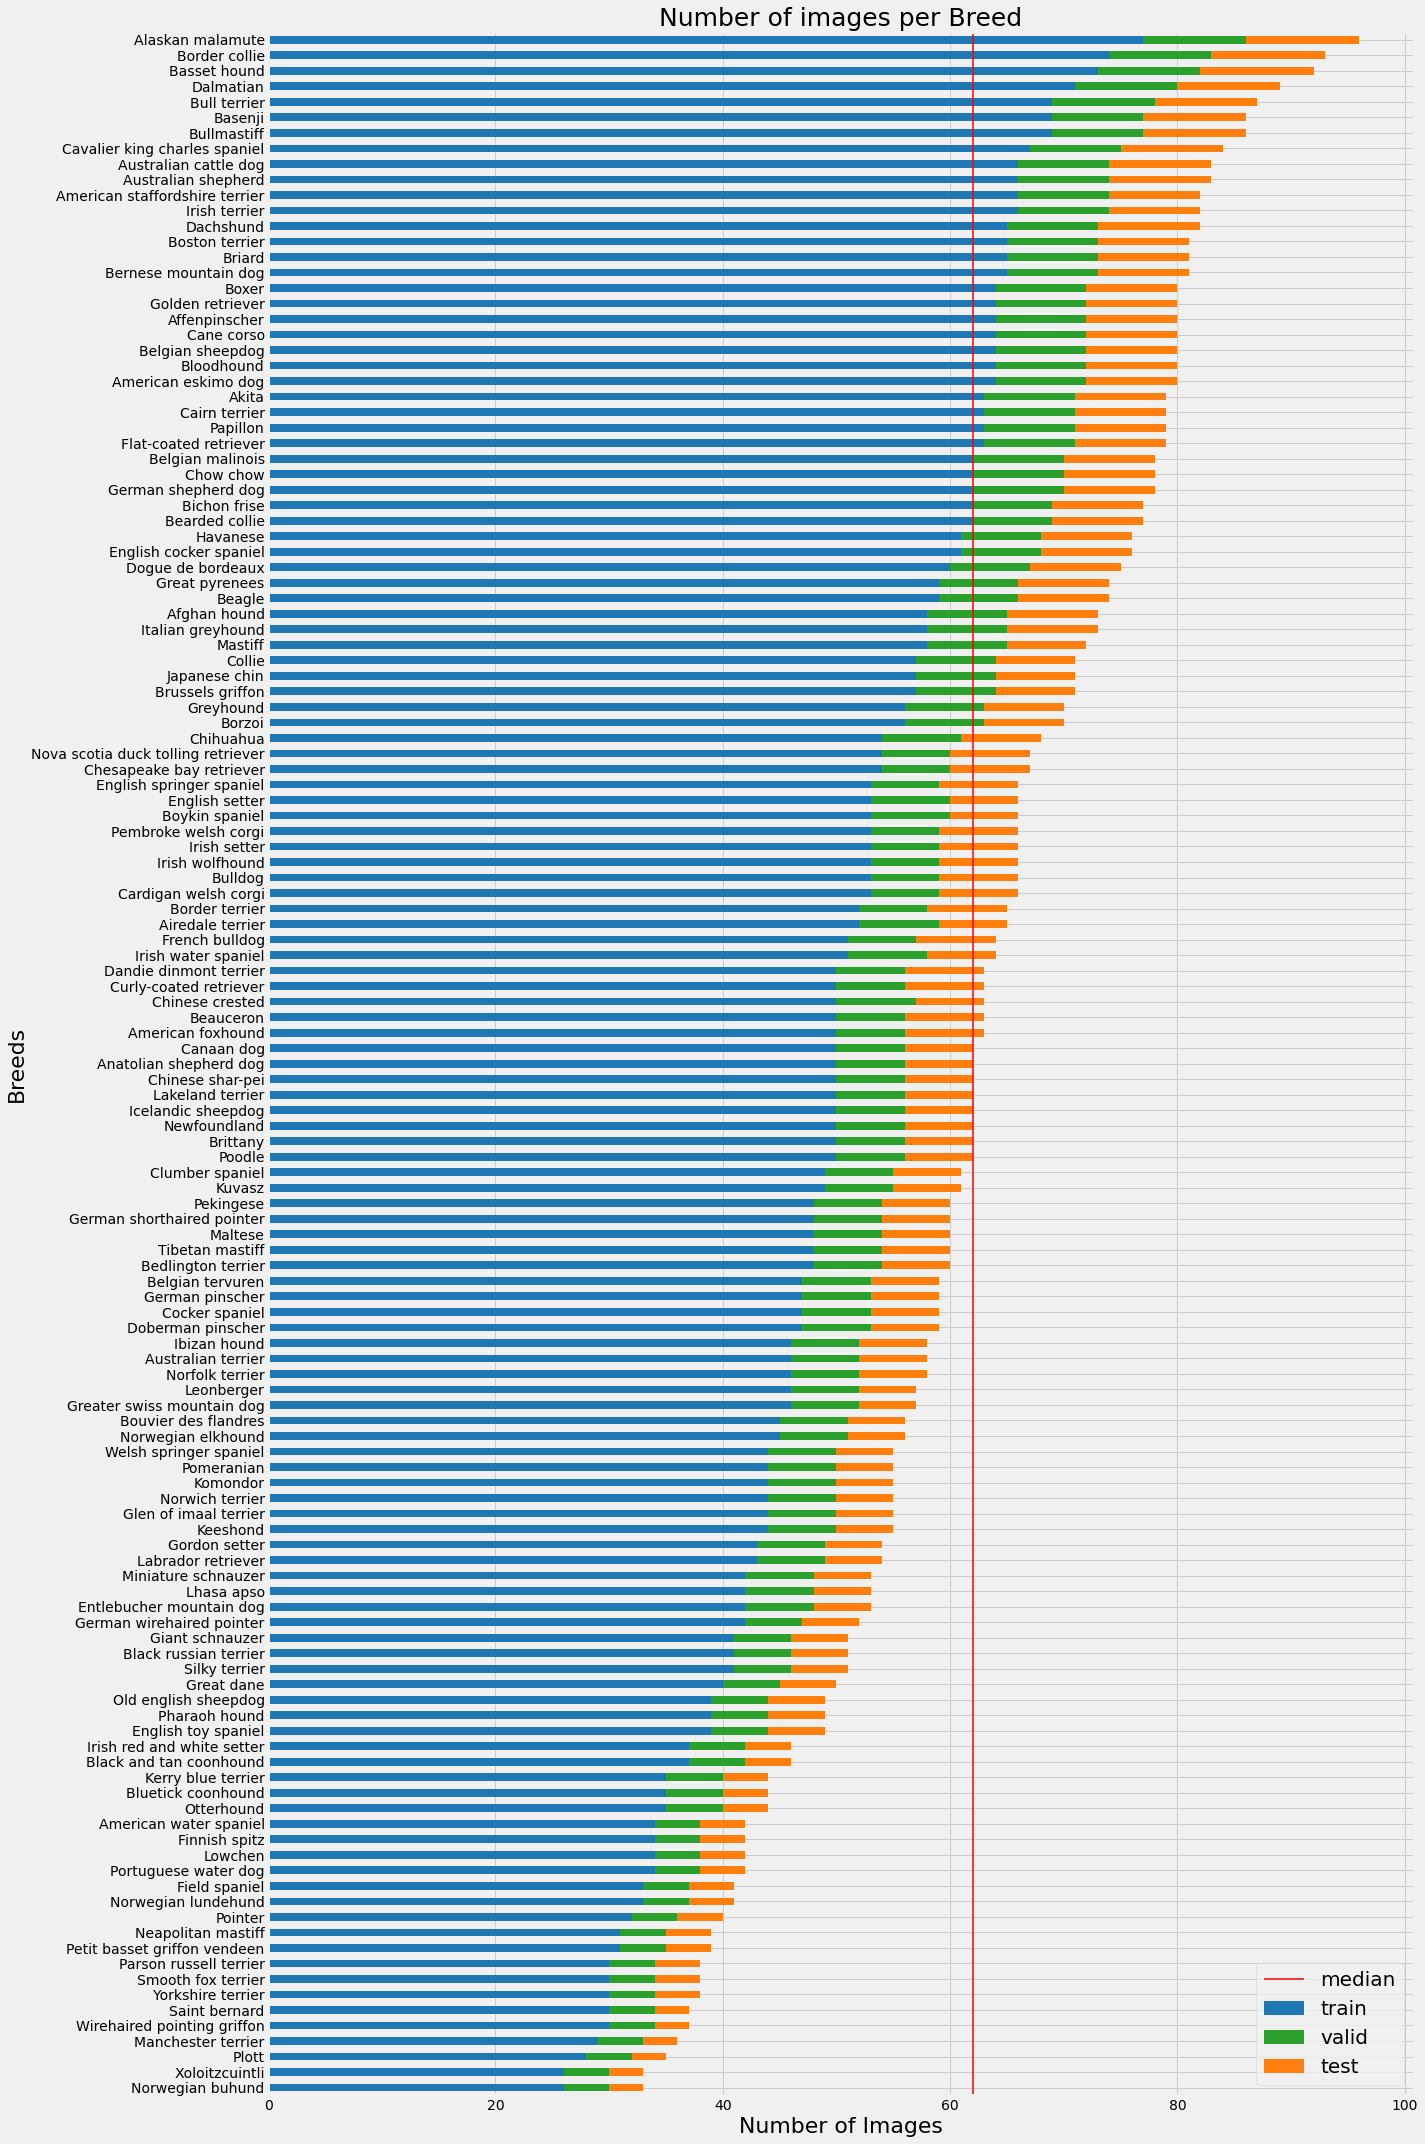

In [9]:
# creating plot
with plt.style.context("fivethirtyeight"):
    fig, ax = plt.subplots(figsize=(20, 30))
    dog_df.sort_values(by="total").plot(
        y=["train", "valid", "test"],
        kind="barh",
        ax=ax,
        color=["tab:blue", "tab:green", "tab:orange"],
        title="Number of images per Breed",
        fontsize=14,
        stacked=True,
    )
    ax.axvline(dog_df.total.median(), color="r", label="median", linewidth=1.5)
    ax.title.set_size(25)
    ax.set_xlabel("Number of Images", fontsize=22)
    ax.set_ylabel("Breeds", fontsize=22)
    plt.legend(prop={"size": 20})
    fig.tight_layout()

We see that the breed categories are slightly imbalanced with some categories having 3x more images, though the imbalance appears to be shared among the splits and, given the number of categories, can be neglected.

<a id='step1'></a>
## Step 1: Make a face detector

We first make use of OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades). We have downloaded one of these detectors and stored it in the `app/models` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image. Note that it is standard procedure to convert the input image to grayscale before applying the model.

**Note:** If running on Google Colab or if there is a problem finding the cascades .xml file, use the following f-string as the haarcascades path: ``f"{cv2.data.haarcascades}haarcascade_frontalface_alt.xml"``.



Number of faces detected: 1


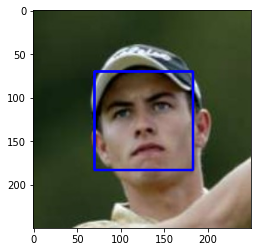

In [10]:
# load color (BGR) image & convert to grayscale
img = cv2.imread(str(human_files[1]))  # imread takes string as input
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# extract pre-trained face detector and find faces in image
haarcascades_path = "app/models/haarcascade_frontalface_alt.xml"
face_cascade = cv2.CascadeClassifier(haarcascades_path)
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print("Number of faces detected:", len(faces))

# get bounding box for each detected face
for (x, y, w, h) in faces:
    # add bounding box to color image
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

# convert BGR image to RGB for plotting and display along with bounding box
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb);

### Writing a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a file path to an image as input and appears in the code block below.

In [11]:
def face_detector(img_path: Path) -> bool:
    """
    Using opencv's haar cascade classifier to detect human faces in images

    Input:
        img_path: path to an image of type string

    Output:
        True or False depending on whether at least one face detected or not.
    """
    img = cv2.imread(str(img_path), 0)  # 0-flag for greyscale conversion
    faces = face_cascade.detectMultiScale(img)
    return len(faces) > 0

We test out the function on a sample dog image.

This photo contains a human face: False


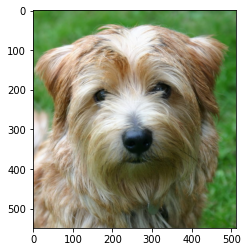

In [12]:
# test
example = dog_train[0]
print("This photo contains a human face:", face_detector(example))
example_im = cv2.cvtColor(cv2.imread(str(example)), cv2.COLOR_BGR2RGB)
plt.imshow(example_im);

### Assessing the Human Face Detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  Let's test our algorithm on sample batches (`human_files_samp` and `dog_files_samp`) of 100 random images from each of the datasets. In the first code cell below, we load the samples.

In [13]:
# We fix a random seed for reproductibility
random.seed(42)

# creating human and dog samples
N_samples = 100
human_files_samp = get_sample(human_files, N_samples)
dog_files_samp = get_sample(dog_train, N_samples)
sample_files = np.hstack((human_files_samp, dog_files_samp))

# Check total number of samples is 2*N_samples
print("Total number of samples:", len(sample_files))

Total number of samples: 200


Next, we apply the ``face_detector`` function to the samples and record the results in the array ``face_detectors_results``. We further store the true values in an array of ones and zeros labelled ``human_dogs``, where 1 corresponds to a human image and 0 to a dog image.

In [14]:
# array of true values
humans_dogs = np.hstack((np.ones(N_samples), np.zeros(N_samples)))
# array of face detection results
face_detector_results = np.fromiter(
    tqdm(face_detector(file) for file in sample_files),
    dtype=int,
    count=2 * N_samples,
);

199it [00:17, 11.33it/s]


Finally, we draw a confusion matrix to display the results:

In [15]:
def plot_cf_matrix(true: np.array, preds: np.array) -> ConfusionMatrixDisplay:
    """
    Function to plot confusion matrix

    Inputs:
        true: numpy array of true/actual values
        preds: numpy array of predicted values
    Outputs:
        Confusion matrix of true values vs predicted
    """
    cm_display = ConfusionMatrixDisplay.from_predictions(
        y_true=true, y_pred=preds, display_labels=[False, True], cmap="Blues"
    )
    return cm_display

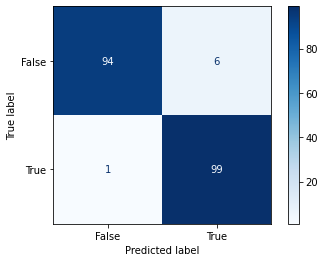

In [16]:
plot_cf_matrix(humans_dogs, face_detector_results)
plt.xlabel = "Face detected"
plt.ylabel = "In humans dataset"

We see that our face detector detects almost every human face from the human samples (high recall),
but also some faces from dog photos (precision <100%). 
We can make a closer examination of the false positives to see whether there are in fact human faces being detected in dog photos or whether dog faces are being detected instead.

Number of false positives: 6


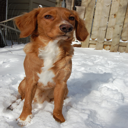

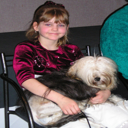

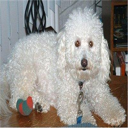

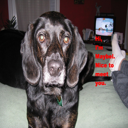

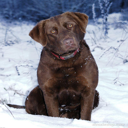

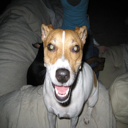

In [17]:
# viewing false positives
fp_indices = np.nonzero(face_detector_results[N_samples:])
fp = dog_files_samp[fp_indices]
print("Number of false positives:", len(fp))
for dog in fp:
    with Image.open(dog) as img:
        display(img.resize((128, 128)))

We see that there are indeed human faces in some of the dog images, though our face detector also detects the faces of some forward-facing dogs!
Since we will be using a dog detector in tandem with the face detector, the above accuracy is entirely sufficient.

---
<a id='step2'></a>
## Step 2: Make a dog detector with pretrained VGG16 CNN from PyTorch Hub

In this section, we use a [pre-trained model](https://pytorch.org/vision/stable/models.html) from pytorch to detect dogs in images. Following the recommendation of the original udacity project, we use the Convolutional Neural Network (CNN) _VGG-16_ pretrained on [ImageNet](http://www.image-net.org/), a very large (consisting of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)), very popular dataset used for image classification and other vision tasks.

The code cell below downloads the VGG-16 model, along with pretrained weights.

In [18]:
# Check for GPU and set device to GPU if available
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load pretrained VGG16 model to device
model = models.vgg16(pretrained=True).to(dev)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Making Predictions with a Pre-trained Model

In the next code cell, we will write a function that accepts a path to an image as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.

In [19]:
def imagenet_predict_idx(img_path: Path) -> int:
    """
    Uses pre-trained VGG-16 model to obtain index corresponding to
    predicted ImageNet class for image at specified path

    Inputs:
        img_path: path to an image

    Outputs:
        Integer index corresponding to VGG-16 model's prediction
    """
    # Load and pre-process an image from the given image path
    img = Image.open(img_path)
    preprocess = transforms.Compose(
        [
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    )
    img_t = preprocess(img)

    # create a mini-batch and load to gpu as expected by the model
    batch_t = torch.unsqueeze(img_t, 0).to(dev)

    # initialise model
    model.eval()

    # Use the model and print the predicted category
    probs = model(batch_t).squeeze(0).softmax(0)
    class_id = probs.argmax().item()
    return class_id  # predicted class index

### Write a Dog Detector

From the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) of Imagenet classes, we see that the classes corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268 inclusive, to include all classes from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268.

We use this idea to write a `dog_detector` function below, which returns `True` if a dog is detected in an image and `False` if not.

Is this a dog?


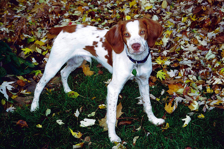

True


In [20]:
# Set dog indices as constant
DOG_IDXS = np.arange(151, 269)


def dog_detector(img_path: Path) -> bool:
    """
    Function returns "True" if a dog is detected in the input image.

    Input:
        img_path: path to image as str/path.
    Output:
        True/False if dog detected or not.
    """
    image_index = imagenet_predict_idx(img_path)
    return image_index in DOG_IDXS


# test
example = dog_files_samp[2]
print("Is this a dog?")
with PILImage.create(example) as im:
    display(im.to_thumb(224))
    print(f"{dog_detector(example)}")

### Assessment of the Dog Detector

Similary to the assessment of the face detector, we test how well the ``dog_detector`` detects dogs in dog images vs human images.

In [21]:
# array of true values: 1 for dog image, 0 for humans
dogs_humans = np.hstack((np.zeros(N_samples), np.ones(N_samples)))
# array of dog detection results
dog_detector_results = np.fromiter(
    tqdm(dog_detector(file) for file in sample_files),
    dtype=int,
    count=2 * N_samples,
);

199it [00:06, 33.02it/s]


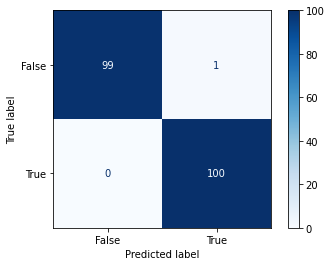

In [22]:
plot_cf_matrix(dogs_humans, dog_detector_results)
plt.xlabel = "Dog detected"
plt.ylabel = "In dogs dataset"

Our dog detector achieves 100% accuracy on the random sample! Repeating the assessment with other random samples yields approximately similar results. Considering that the two categories of dog breeds (one from our dataset and one from imagenet) are not even the same, the results are more than sufficient.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds using Transfer Learning

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images. 
Before we begin we mention that the task of classifying dog breeds from images is known to be considered exceptionally challenging due to low inter-class variation but sometimes high variation within a single class. For example, it is hard even for humans, to distinguish between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="walkthrough_imgs/Brittany_02625.jpg" width="100"> | <img src="walkthrough_imgs/Welsh_springer_spaniel_08203.jpg" width="200">

Due to the large number of different breeds, random guessing also presents an exceptionally low bar. Indeed, ignoring class imbalances, a random guess would be correct less than 1% of the time!


As above, we will again use a CNN but this time we will fine-tune a pretrained CNN to identify dog breeds from our dataset. This method is usually refered to as _transfer learning_ and has the advantage (over say creating our own CNN from scratch) of exploiting the learned features of a model which has been trained on many more images than ours and already good at its task. 
To build our CNN, we will make use of the powerful and quick-to-implement [fastai library](https://docs.fast.ai/). Fastai is high-level wrapper for deep learning built on top of pytorch that uses state-of-the-art techniques. We remark that our code cells are based on tips gathered from [fastai's introductory book](https://github.com/fastai/fastbook).

### Specifying Data Loaders for the Dog Dataset

Fastai models expect data to be given as a ``dataloader`` object. We load the dog images in this format in the next cell. Note that a dataloader carries out the preprocessing and batch-forming steps. Here we use a batch size of 32 and resize each image firstly to a common size before applying some augmentation transformations (these help mitigate overfitting) per batch. 

Setting-up type transforms pipelines
Found 7515 items
2 datasets of sizes 6680,835
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_breed_name -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      data/dogImages/train/107.Norfolk_terrier/Norfolk_terrier_07088.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=512x549
  Pipeline: get_breed_name -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      data/dogImages/train/107.Norfolk_terrier/Norfolk_terrier_07088.jpg
    applying get_breed_name gives
      Norfolk terrier
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(106)

Final sample: (PILImage mode=RGB size=512x549, TensorCategory(106))


Found 7515 items
2 datasets of sizes 6680,835
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_breed_name -> Categorize -- {'vocab': None, 'sort

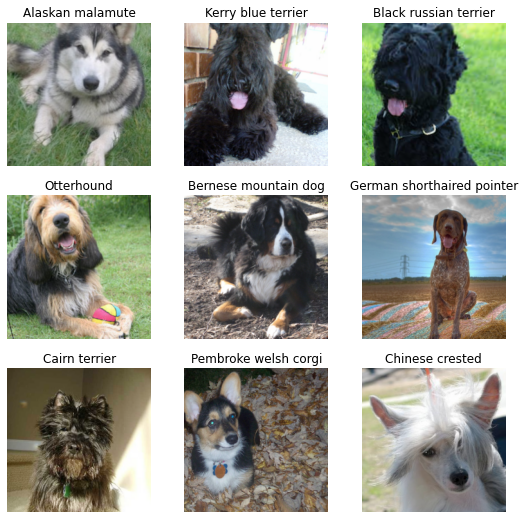

In [23]:
# Initialising data block for training and validation images
dog_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=partial(get_image_files, folders=["train", "valid"]),
    splitter=GrandparentSplitter(valid_name="valid"),
    get_y=get_breed_name,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
)

# check that loading succeeded
dog_block.summary(dog_path)

# Create training and validation dataloader from datablock
train_val_dls = dog_block.dataloaders(dog_path, bs=32)

# Creating test datablock with same augmentations as above
tst_files = dog_tvt["test"]
tst_dl = train_val_dls.test_dl(tst_files, with_labels=True)

# show batch from train and validation dataloaders
train_val_dls.show_batch()

## Training model

For training we must define a "learner" object with corresponding dataloaders, model,
optimisation function and metrics. We choose the _ResNet(-34)_ CNN architecture as our pretrained model as it's a known effective image classifier and can be trained quickly on our machine. Moreover, we will set the default cross-entropy as our loss function. As an optimizer, it turns out that Stochastic Gradient Descent (SGD) gives us better performance than Adam. 

In the next code cell, we load the learner an set the path to where we will save trained models. It should be noted that fastai's ``vision_learner`` automatically normalises our data based the imagenet dataset.

In [24]:
learn = vision_learner(train_val_dls, resnet34, opt_func=SGD, metrics=accuracy)
learn.path = Path("./app/models")

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Before training, we select an appropriate learning rate for gradient descent with the help of fastai's inbuilt learning rate finder.

Minimum/10: 6.31e-02, steepest point: 1.45e-01


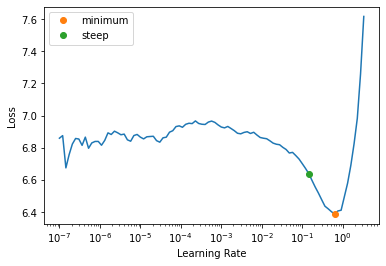

In [25]:
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

The recommended learner rate lies on the downward slope before the last minimum (when the loss is clearly decreasing) and usually lies between the point of minimum loss/10 (``lr_min``) and point of steepest descent (``lr_steep``). In this case 1e-1 seems like a reasonable value.

Now we will fine-tune our model for 9 epochs and plot the training and validation loss per epoch. Note that the fine-tune method fits the head of the model while freezing all earlier layers in the first epoch and then fine-tunes all weights in the following epochs.

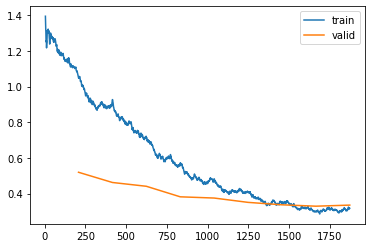

In [27]:
learn.fine_tune(9, 1e-1)
learn.recorder.plot_loss()

Wow! Our model reaches almost 90% accuracy on the validation set after only a few epochs of training! This would not have been possible without a pretrained model. Based on the loss curves, our model would appear to overfit if we train any longer.

Now that the model is trained, let's test it out and see where it makes mistakes.

### Testing

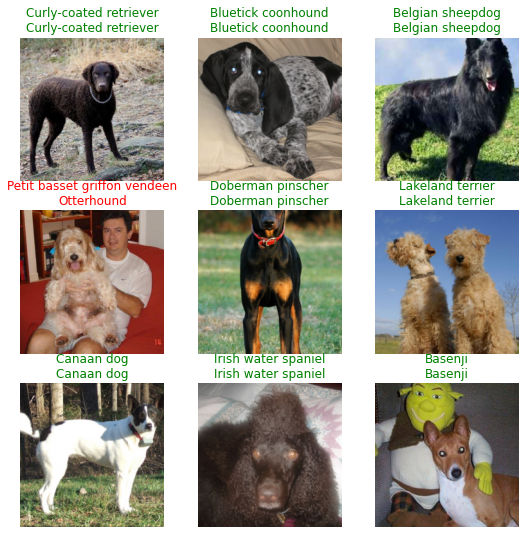

In [30]:
learn.show_results()

As we can see, our model has high accuracy, and makes mistakes on some harder-to-distinguish cases.

### Interpreting results

We next examine the mistakes our model makes in more detail using fastai's helper interpretation functions. 
In the next code cell we display the 10 images with highest loss:

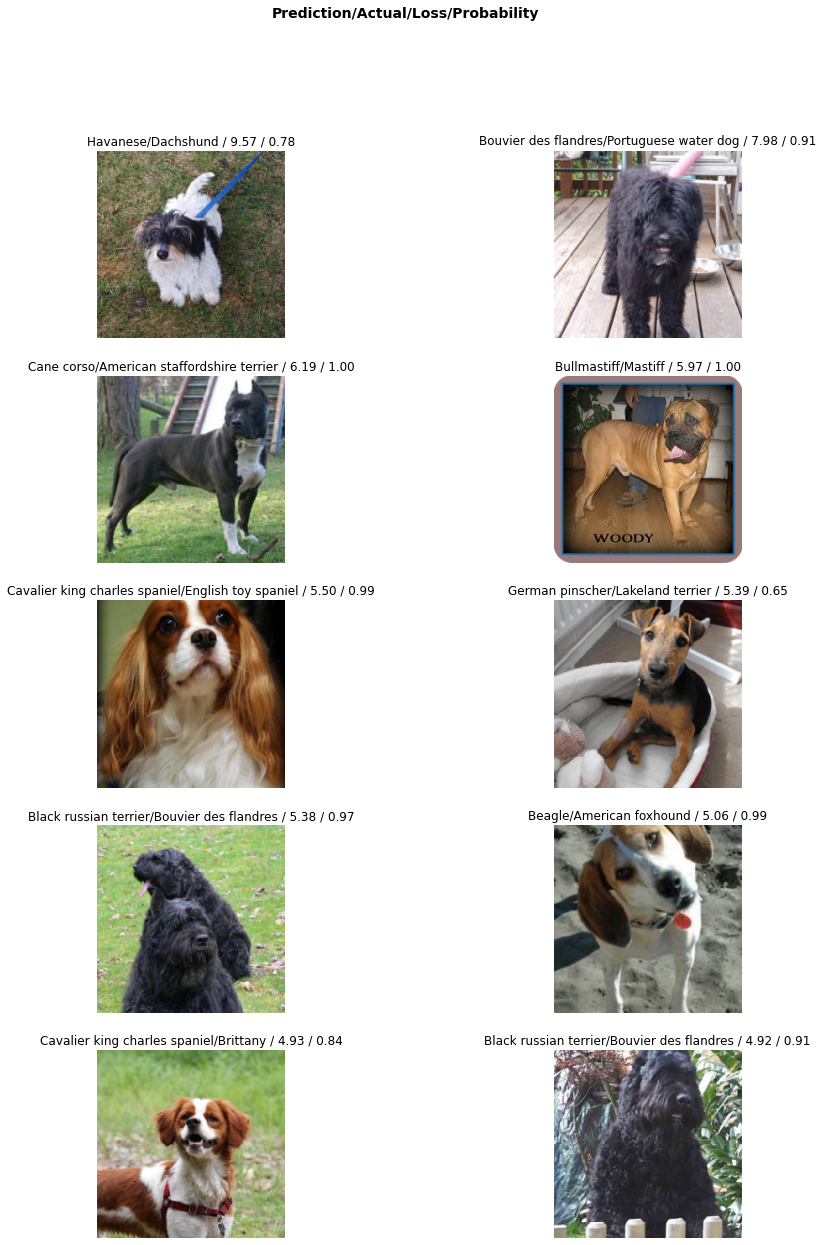

In [29]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(10, nrows=5, figsize=(15, 20))

We can see that our model is at times overconfident (e.g. Beagle/American foxhound) and sometimes unsure (e.g. German Pinscher/Lakeland Terrier). In the examples of overconfidence it's hard without expert knowledge to know if our model is making mistakes or whether some images were mislabled!  In the other cases, we expect these are genuine faults of our model and would improve with more training examples.

We finally record the breeds our model most often confuses (with at least two examples occuring):

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(2)

[('Cardigan welsh corgi', 'Pembroke welsh corgi', 3),
 ('American foxhound', 'Beagle', 2),
 ('Bouvier des flandres', 'Black russian terrier', 2),
 ('Boykin spaniel', 'Field spaniel', 2),
 ('Cavalier king charles spaniel', 'English toy spaniel', 2),
 ('English toy spaniel', 'Cavalier king charles spaniel', 2),
 ('Great pyrenees', 'Kuvasz', 2),
 ('Lowchen', 'Havanese', 2)]

Here, we rather observe that the main breeds causing our model difficulty are those which would are really difficult to distinguish just with a picture. 

Satisfied with our model's performance, we will save the model and perform inference on the test set.

In [32]:
learn.export(fname="breed_model.pkl")

### Inference on the Test set
We will test out our model's generalisation power by recording its accuracy on the unseen test set. Our goal is to achieve at least 60% accuracy (as set out in the original Udacity repo).

In [33]:
# load learner for inference
learn_inf = load_learner("./app/models/breed_model.pkl")

In [34]:
# Gathering predictions for test set
preds, targets = learn_inf.get_preds(dl=tst_dl)

In [35]:
# Gathering prediction indices
preds_idx = tensor([preds[i, :].argmax().item() for i in range(len(tst_files))])
# generate boolean array of whether predicted label is true label
correct = preds_idx == targets
# compute accuracy
accuracy = correct.float().mean().item()
print(f"Test set accuracy: {accuracy*100:.4f}%")

Test set accuracy: 71.0526%


Great! We obtain an accuray of 71% on our test data :) Although this is less than that of the validation set (suggesting possible data shift in the test set), it is good enough for deployment. 

---
<a id='step4'></a>
## Step 4: Write app

We next combine the above functions into an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if __both__ are detected in the image, it asks for cropped input image showing only dog or human.
- if only a __dog__ is detected in the image, it returns the predicted breed.
- if only a __human__ is detected in the image, it returns the resembling dog breed.
- if __neither__ is detected in the image, it indicates an error.

We can already detect humans and dogs in the image using the functions, ``face_detector`` and ``dog_detector``, respectively. Next, we write an inference function making use of the previously trained model in the last section, that given an image path returns the dog breed predictions as a dictionary with corresponding confidence levels.

In [36]:
def breed_identifier(img_path: Path) -> dict[str, float]:
    """
    Function to identify dog breed from a possible of 133 categories in the
    udacity dog dataset. It takes an image path, and returns breed and
    probabilities for all breeds. We use a preloaded fastai vision learner
    as a model.

    Inputs:
        img_path: file path to image
    Outputs:
        Dictionary whose keys are the breed categories
        and values are the corresponding probabilities
        rounded to 4 decimal points.
    """
    img = PILImage.create(img_path)
    _, _, probs = learn_inf.predict(img)
    return {breeds[i]: round(float(probs[i]), 4) for i in range(len(breeds))}

Finally, we string all our models together to get the desired behaviour.

In [37]:
def run_app(img_path: Path) -> tuple[str, dict[str, float] or None]:
    """
    App predicts most resembling dog breeds from image of human or dog.
    Logic handles cases for a human, dog, both or neither.

    Inputs:
        img_path = path to image
    Outputs:
        detection: Output display message stored as string
        preds: Dictionary of form (breed labels: probabilities).
    """
    # detect humans/ dogs
    face_detected = face_detector(img_path)
    dog_detected = dog_detector(img_path)

    # if both human and dog detected: output error message
    if face_detected and dog_detected:
        detection = (
            "Both human and dog found! Please crop the image "
            "until only a person or dog are showing to obtain a prediction"
        )
        return detection, None
    # if neither human or dog detected: output error message
    elif not face_detected and not dog_detected:
        detection = (
            "No human or dog found! Please zoom in by cropping "
            "or upload a new image."
        )
        return detection, None
    # if only a human OR a dog detected: output relevant message
    # and run breed identifier.
    else:
        detection = (
            "Human detected! Your identification results are:"
            if face_detected
            else "Dog detected! The most resembling breeds are:"
        )
        preds = breed_identifier(img_path)
        return detection, preds

Before creating the app interface, we test that the algorithm works for sample images:

Human detected! Your identification results are:
('Collie', 0.1294)
('Belgian tervuren', 0.061)
('Ibizan hound', 0.0573)


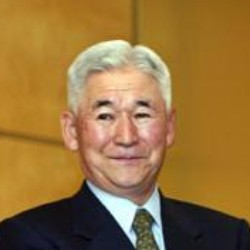

Human detected! Your identification results are:
('American foxhound', 0.1103)
('Ibizan hound', 0.0971)
('Collie', 0.0901)


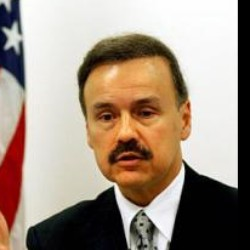

Human detected! Your identification results are:
('Dogue de bordeaux', 0.2459)
('French bulldog', 0.1632)
('Bull terrier', 0.0689)


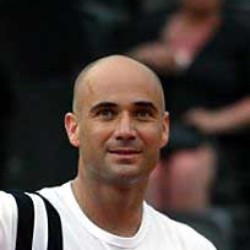

Dog detected! The most resembling breeds are:
('American staffordshire terrier', 0.982)
('Cane corso', 0.0104)
('Boston terrier', 0.0047)


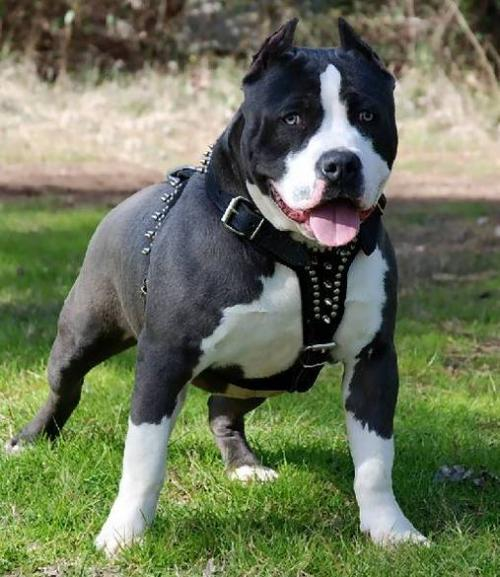

Dog detected! The most resembling breeds are:
('Irish water spaniel', 0.9998)
('American water spaniel', 0.0001)
('Affenpinscher', 0.0)


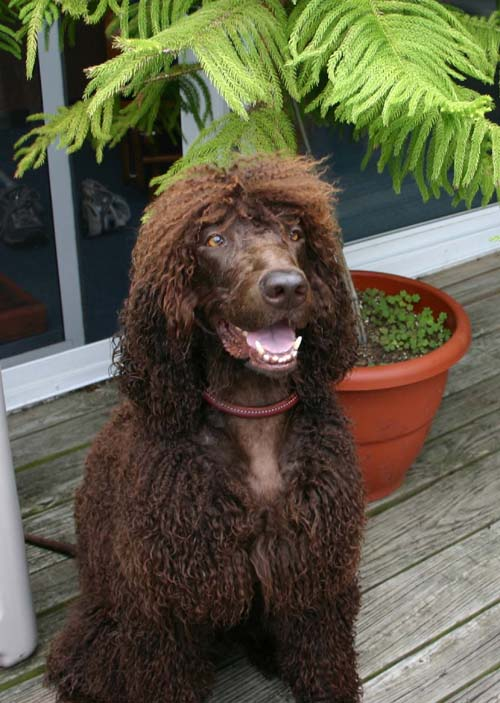

Dog detected! The most resembling breeds are:
('Brittany', 0.9997)
('Irish red and white setter', 0.0001)
('Pointer', 0.0001)


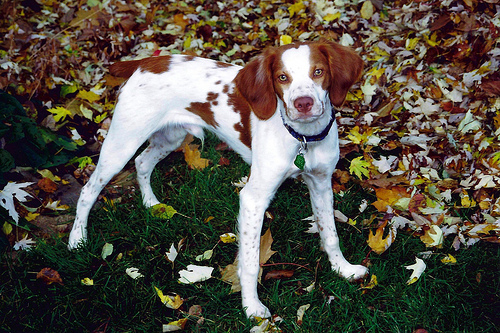

In [38]:
# test
for file in np.hstack((human_files_samp[:3], dog_files_samp[:3])):
    detection, preds = run_app(file)
    top_5_preds = sorted(preds.items(), key=itemgetter(1), reverse=True)[:3]
    with PILImage.create(file) as img_file:
        print(detection)
        print(*top_5_preds, sep="\n")
        display(img_file)

### Create app with Gradio

Now that we have our wanted algorithm, [Gradio](https://www.gradio.app) provides an eady API to make it into a pretty demo app! The setup is rather straightforward and we have followed the instructions of the readable [blogpost](https://tmabraham.github.io/blog/gradio_hf_spaces_tutorial) by Tanishq in the code cell below. Before running the next cell, upload some example images into ``app/img_examples``.

### Preparing app attributes

In [39]:
title = "Dog Identifier"
description = """
Upload an image of a dog or human, or try an example from below. \
The app returns the top 3 dog breeds they resemble and the corresponding \
confidences!

**Note**: Cropped and zoomed-in images showing only a dog or human \
yield better predictions.
"""
article = """

___

<p style="text-align: center;">
</li>
<a href="https://github.com/alexeikud/identidog"
target="_blank">
Github Repo<a>
</p>
"""
inputs = gr.components.Image(type="filepath", shape=(512, 512), label="image")
outputs = [
    gr.components.Textbox(label="Output:"),
    gr.components.Label(label="Identification results", num_top_classes=3),
]

# input image examples
EXAMPLES_FOLDER = Path("./app/img_examples")
examples = [str(img_file) for img_file in EXAMPLES_FOLDER.iterdir()]

### Launching app

In [ ]:
app = gr.Interface(
    fn=run_app,
    inputs=inputs,
    outputs=outputs,
    title=title,
    description=description,
    article=article,
    examples=examples,
    allow_flagging="never",
)
app.launch();

<a id='step5'></a>
## Step 5: Final Thoughts
Now that we have a working app, I mention some suggestions for future work:

Suggestions to improve app's accuracy:
- Examine the data more thoroughly and remove any images showing multiple dogs of different breeds/mislabelled images.
- Retrain the breed identification model on more images (for example using the whole dataset and any other external images).
- Try out other other CNN architectures such as ConvNext/Xception.
- Experiment with other data augmentation techniques.
- Implement test time augmentation (though this would slow down inference).

Suggestions for UX:
- Embed app in stand-alone webpage.
- Customize UI with CSS and Javascript.
- Add information about each breed into app's output.

Domain extensions:
- Extend to more dog breed categories. This of course requires more training data. In particular, I would like to include two of my favourite breeds: Black/ White German Shepherds.
- Finally, note that our app is trained on images of pure-breed dogs, and thus images of mixed-breed dogs are in a sense out-of-domain cases, or at the very least underrepresented. It would be rather interesting to see whether incorporating images of _verified_ mix-breeds (say terrier mix (full-cross not known), or where cross is known, e.g. terrier-spaniel mix) into training would yield better results or if another classifier could be fine-tuned solely for recognising mixed-breeds.

--

In the last code cell we save how to export the working environment and library requirements.

In [ ]:
# !conda env export > environment.yml --no-builds
# !pip list --format=freeze > requirements.txt